In [1]:
import IPython as ipy
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils
import torch.optim as optim
import torch.utils.data as data
from tqdm.auto import tqdm

import itertools as it
import time

from ner import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)

device: cuda


In [2]:
#tok_to_id, glv_emb = load_emb('data/glove/glove.6B.100d.txt', int(4e5))
#torch.save((tok_to_id, glv_emb), 'data/pt-cache/tok_to_id__glv_emb.pt')
tok_to_id, glv_emb = torch.load('data/pt-cache/tok_to_id__glv_emb.pt')

In [3]:
#chr_to_id = load_chrs('data/ner-gmb/train.txt')
#torch.save(chr_to_id, 'data/pt-cache/chr_to_id.pt')
chr_to_id = torch.load('data/pt-cache/chr_to_id.pt')

In [4]:
#lbl_to_id, id_to_lbl = load_classes('data/ner-gmb/train.txt')
#torch.save((lbl_to_id, id_to_lbl), 'data/pt-cache/lbl_to_id__id_to_lbl')
lbl_to_id, id_to_lbl = torch.load('data/pt-cache/lbl_to_id__id_to_lbl')

In [5]:
#train_X, train_Y, train_W = load_data('data/ner-gmb/train.txt', tok_to_id, lbl_to_id, chr_to_id)
#torch.save((train_X, train_Y, train_W), 'data/pt-cache/train_X__train_Y__train_W.pt')
train_X, train_Y, train_W = torch.load('data/pt-cache/train_X__train_Y__train_W.pt')

In [6]:
#dev_X, dev_Y, dev_W = load_data('data/ner-gmb/dev.txt', tok_to_id, lbl_to_id, chr_to_id)
#torch.save((dev_X, dev_Y, dev_W), 'data/pt-cache/dev_X__dev_Y__dev_W.pt')
dev_X, dev_Y, dev_W = torch.load('data/pt-cache/dev_X__dev_Y__dev_W.pt')

In [7]:
#test_X, test_Y, test_W = load_data('data/ner-gmb/test.txt', tok_to_id, lbl_to_id, chr_to_id)
#torch.save((test_X, test_Y, test_W), 'data/pt-cache/test_X__test_Y__test_W.pt')
test_X, test_Y, test_W = torch.load('data/pt-cache/test_X__test_Y__test_W.pt')

In [ ]:
assert(lbl_to_id['PAD_LBL'] == len(lbl_to_id)-1)
rand_model = NERModel(
    embed_model=TokEmbModel(
        init_emb=torch.randn(len(tok_to_id), 100),
        pad_tok_id=tok_to_id['PAD_TOK']
    ),
    seq_tag_model=SeqTagModel(
        input_size=100,
        hidden_size=100,
        output_size=len(lbl_to_id)-1,
        dropout_prob=0.5
    ),
    pad_lbl_id=lbl_to_id['PAD_LBL'],
    pad_tok_id=tok_to_id['PAD_TOK'],
    class_freq=torch.bincount(train_Y.reshape(-1))[:-1]
)
#rand_model.load_state_dict(torch.load('data/pt-cache/rand_model.pt'))

In [9]:
train_loop(
    train_set=(train_W, train_X, train_Y),
    dev_set=(dev_W, dev_X, dev_Y),
    model=rand_model.to(device),
    opt=optim.Adam(rand_model.parameters(), lr=0.001),
    n_classes=len(lbl_to_id)-1,
    batch_size=128,
    grad_clip_norm=5,
    pred_batch_size=4096
)

KeyboardInterrupt: 

In [ ]:
torch.save(rand_model.state_dict(), 'data/pt-cache/rand_model.pt')

In [ ]:
test_pred = rand_tok_model.to(device).batch_predict(test_X, 4096)
print(conll_report(test_Y, test_pred, id_to_lbl, lbl_to_id['PAD_LBL']))

In [ ]:
assert(lbl_to_id['PAD_LBL'] == len(lbl_to_id)-1)
glv_model = NERModel(
    embed_model=TokEmbModel(
        init_emb=glv_emb,
        pad_tok_id=tok_to_id['PAD_TOK']
    ),
    seq_tag_model=SeqTagModel(
        input_size=100,
        hidden_size=100,
        output_size=len(lbl_to_id)-1,
        dropout_prob=0.5
    ),
    pad_lbl_id=lbl_to_id['PAD_LBL'],
    pad_tok_id=tok_to_id['PAD_TOK'],
    class_freq=torch.bincount(train_Y.reshape(-1))[:-1]
)
#glv_model.load_state_dict(torch.load('data/pt-cache/glv_model.pt'))

In [ ]:
train_loop(
    train_set=(train_W, train_X, train_Y),
    dev_set=(dev_W, dev_X, dev_Y),
    model=glv_model.to(device),
    opt=optim.Adam(glv_model.parameters(), lr=0.01),
    n_classes=len(lbl_to_id)-1,
    batch_size=128,
    pred_batch_size=4096,
    grad_clip_norm=5
)

In [ ]:
torch.save(glv_model.state_dict(), 'data/pt-cache/glv_model.pt')

In [ ]:
test_pred = glv_model.to(device).batch_predict(test_X, 4096)
print(conll_report(test_Y, test_pred, id_to_lbl, lbl_to_id['PAD_LBL']))

In [2]:
chr_glv_model = NERModel(
    embed_model=ChrTokEmbModel(
        chr_emb_model=ChrEmbModel(
            n_embs=len(chr_to_id),
            pad_chr_id=chr_to_id['PAD_CHR'],
            emb_size=8,
            hidden_size=25
        ),
        tok_emb_model=nn.Embedding.from_pretrained(
            glv_emb,
            freeze=False,
            padding_idx=tok_to_id['PAD_TOK']
        )
    ),
    seq_tag_model=SeqTagModel(
        input_size=150,
        hidden_size=100,
        output_size=len(lbl_to_id)-1,
        dropout_prob=0.5
    ),
    pad_lbl_id=lbl_to_id['PAD_LBL'],
    pad_tok_id=tok_to_id['PAD_TOK'],
    class_freq=torch.bincount(train_Y.reshape(-1))[:-1]
)
#chr_glv_model.load_state_dict(torch.load('data/pt-cache/chr_glv_model.pt'))

NameError: name 'NERModel' is not defined

In [ ]:
train_loop(
    train_set=(train_W, train_X, train_Y),
    dev_set=(dev_W, dev_X, dev_Y),
    model=chr_glv_model.to(device),
    opt=optim.Adam(chr_glv_model.parameters(), lr=0.001),
    n_classes=len(lbl_to_id)-1,
    batch_size=128,
    pred_batch_size=2048,
    grad_clip_norm=5
)

In [ ]:
torch.save(chr_glv_model.state_dict(), 'data/pt-cache/glv_model.pt')

In [ ]:
test_pred = chr_glv_model.to(device).batch_predict(test_W, test_X, 4096)
print(conll_report(test_Y, test_pred, id_to_lbl, lbl_to_id['PAD_LBL']))

In [8]:
assert(lbl_to_id['PAD_LBL'] == len(lbl_to_id)-1)
ln_glv_model = NERModel(
    embed_model=TokEmbModel(
        init_emb=glv_emb,
        pad_tok_id=tok_to_id['PAD_TOK']
    ),
    seq_tag_model=LNSeqTagModel(
        input_size=100,
        hidden_size=100,
        output_size=len(lbl_to_id)-1,
        dropout_prob=0.5
    ),
    pad_lbl_id=lbl_to_id['PAD_LBL'],
    pad_tok_id=tok_to_id['PAD_TOK'],
    class_freq=torch.bincount(train_Y.reshape(-1))[:-1]
)
#ln_glv_model.load_state_dict(torch.load('data/pt-cache/ln_glv_model.pt'))

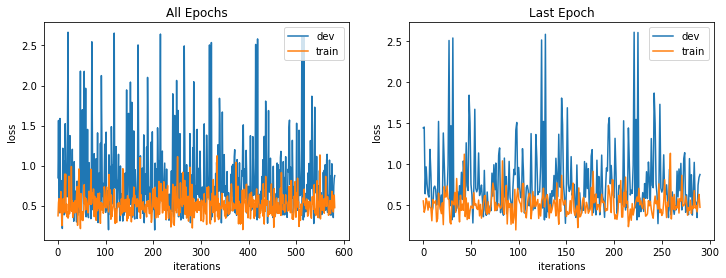

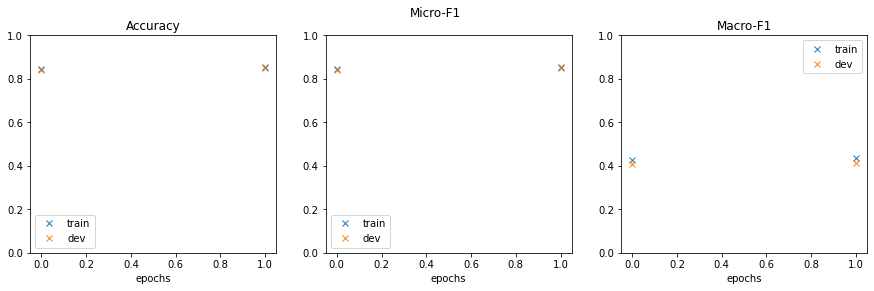

0.4750710129737854
0.8744432926177979


KeyboardInterrupt: 

In [20]:
train_loop(
    train_set=(train_W, train_X, train_Y),
    dev_set=(dev_W, dev_X, dev_Y),
    model=ln_glv_model.to(device),
    opt=optim.Adam(ln_glv_model.parameters(), lr=0.0001),
    n_classes=len(lbl_to_id)-1,
    batch_size=128,
    pred_batch_size=4096,
    grad_clip_norm=5
)

In [21]:
torch.save(ln_glv_model.state_dict(), 'data/pt-cache/ln_glv_model.pt')

In [22]:
test_pred = ln_glv_model.to(device).batch_predict(test_W, test_X, 4096)

In [23]:
tic = time.time()
print(conll_report(test_Y, test_pred, id_to_lbl, lbl_to_id['PAD_LBL']))
toc = time.time()
print(toc-tic)

              precision    recall  f1-score   support

         art       0.01      0.32      0.02       102
         eve       0.04      0.52      0.07        87
         geo       0.60      0.79      0.68      9912
         gpe       0.78      0.87      0.82      4168
         nat       0.04      0.58      0.07        55
         org       0.24      0.44      0.31      5205
         per       0.55      0.74      0.63      4406
         tim       0.24      0.49      0.32      5275

   micro avg       0.40      0.67      0.50     29210
   macro avg       0.31      0.59      0.37     29210
weighted avg       0.48      0.67      0.56     29210

11.826610326766968


In [43]:
ln_chr_glv_model = NERModel(
    embed_model=ChrTokEmbModel(
        chr_emb_model=ChrEmbModel(
            n_embs=len(chr_to_id),
            pad_chr_id=chr_to_id['PAD_CHR'],
            emb_size=16,
            hidden_size=25
        ),
        tok_emb_model=nn.Embedding.from_pretrained(
            glv_emb,
            freeze=False,
            padding_idx=tok_to_id['PAD_TOK']
        )
    ),
    seq_tag_model=LNSeqTagModel(
        input_size=150,
        hidden_size=100,
        output_size=len(lbl_to_id)-1,
        dropout_prob=0.5
    ),
    pad_lbl_id=lbl_to_id['PAD_LBL'],
    pad_tok_id=tok_to_id['PAD_TOK'],
    class_freq=torch.tensor([1]*(len(lbl_to_id)-1))#torch.bincount(train_Y.reshape(-1))[:-1]
)
#ln_chr_glv_model.load_state_dict(torch.load('data/pt-cache/ln_chr_glv_model.pt'))

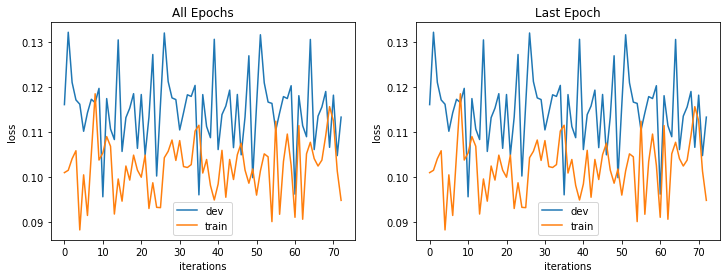

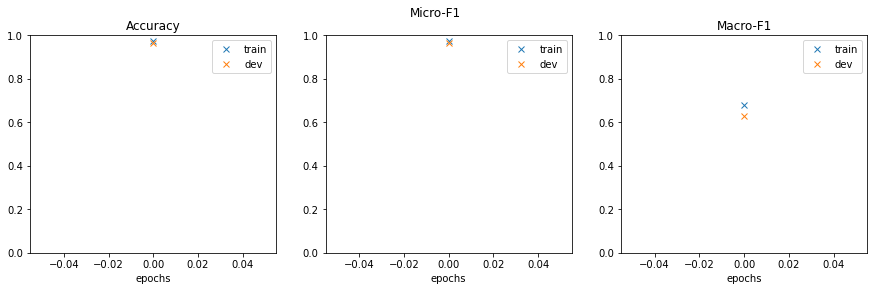

0.09473961591720581
0.11324312537908554


KeyboardInterrupt: 

In [60]:
train_loop(
    train_set=(train_W, train_X, train_Y),
    dev_set=(dev_W, dev_X, dev_Y),
    model=ln_chr_glv_model.to(device),
    opt=optim.Adam(ln_chr_glv_model.parameters(), lr=0.0001),
    n_classes=len(lbl_to_id)-1,
    batch_size=512,
    pred_batch_size=2048,
    grad_clip_norm=5
)

In [61]:
torch.save(ln_glv_model.state_dict(), 'data/pt-cache/ln_chr_glv_model.pt')

In [62]:
test_pred = ln_chr_glv_model.to(device).batch_predict(test_W, test_X, 4096)

In [63]:
tic = time.time()
print(conll_report(test_Y, test_pred, id_to_lbl, lbl_to_id['PAD_LBL']))
toc = time.time()
print(toc-tic)

              precision    recall  f1-score   support

         art       0.33      0.03      0.05       102
         eve       0.36      0.32      0.34        87
         geo       0.81      0.89      0.85      9912
         gpe       0.92      0.91      0.92      4168
         nat       0.40      0.35      0.37        55
         org       0.67      0.56      0.61      5205
         per       0.74      0.77      0.75      4406
         tim       0.83      0.86      0.85      5275

   micro avg       0.80      0.81      0.80     29210
   macro avg       0.63      0.59      0.59     29210
weighted avg       0.79      0.81      0.80     29210

11.53419804573059
